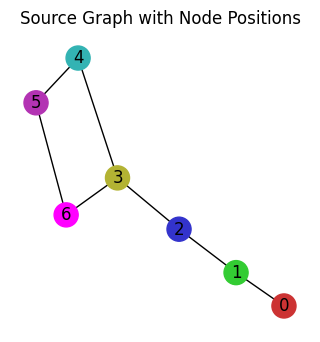

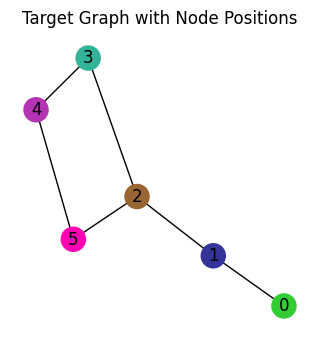

torch.Size([3, 7]) torch.Size([3, 6]) torch.Size([7, 7]) torch.Size([6, 6])


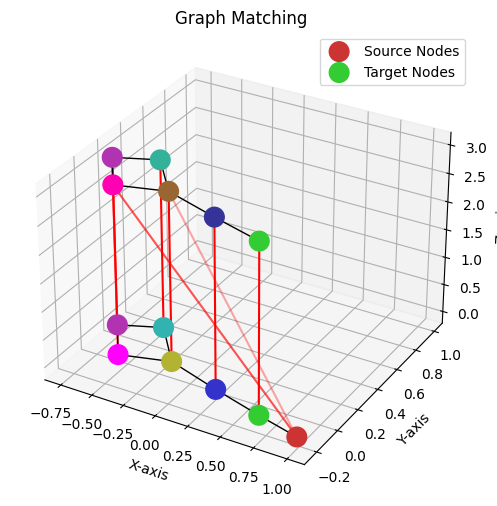

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from fugw_solver.solver import solver
import torch
from collections import defaultdict

###CREATE GRAPHS 

source_adjacency_matrix = np.array([[0, 1, 0, 0, 0, 0, 0],
                             [1, 0, 1, 0, 0, 0, 0],
                             [0, 1, 0, 1, 0, 0, 0],
                             [0, 0, 1, 0, 1, 0, 1],
                             [0, 0, 0, 1, 0, 1, 0],
                             [0, 0, 0, 0, 1, 0, 1],
                             [0, 0, 0, 1, 0, 1, 0]])

n_points_source = len(source_adjacency_matrix)

source_graph = nx.Graph(source_adjacency_matrix)

source_geometry = nx.floyd_warshall_numpy(source_graph)

source_locations = nx.spring_layout(source_graph)

source_node_colors = {
    0: (0.8, 0.2, 0.2),  # Red
    1: (0.2, 0.8, 0.2),  # Green
    2: (0.2, 0.2, 0.8),  # Blue
    3: (0.7, 0.7, 0.2),  # Yellow
    4: (0.2, 0.7, 0.7),  # Cyan
    5: (0.7, 0.2, 0.7),   # Magenta
    6: (1, 0, 1)
}
source_features = list(source_node_colors.values())

nx.set_node_attributes(source_graph, source_node_colors, 'color')
source_node_colors = nx.get_node_attributes(source_graph, 'color').values()

plt.figure(figsize=(3, 3))
nx.draw(source_graph, source_locations, node_color=list(source_node_colors), with_labels=True)
plt.title('Source Graph with Node Positions')
plt.show()

target_node_colors = {
    0: (0.2, 0.8, 0.2),  # Green
    1: (0.2, 0.2, 0.6),  # Blue
    2: (0.6, 0.4, 0.2),  # Yellow
    3: (0.2, 0.7, 0.6),  # Cyan
    4: (0.7, 0.2, 0.7),   # Magenta
    5: (1, 0, 0.7)
}
target_features = list(target_node_colors.values())

target_graph = source_graph.copy()

target_graph.remove_node(0)

mapping = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}

target_graph = nx.relabel_nodes(target_graph, mapping)

nx.set_node_attributes(target_graph, target_node_colors, 'color')

target_node_colors = nx.get_node_attributes(target_graph, 'color').values()

target_geometry = nx.floyd_warshall_numpy(target_graph)

source_locations_without_first = source_locations.copy()

source_locations_without_first.pop(0, None)

target_locations = {new_node: source_locations_without_first[old_node] for new_node, old_node in enumerate(source_locations_without_first.keys())}

plt.figure(figsize=(3, 3))
nx.draw(target_graph, target_locations, node_color=list(target_node_colors), with_labels=True)
plt.title('Target Graph with Node Positions')
plt.show()

###CREATE GEOMETRY AND FEATURES

source_features = torch.tensor(source_features, dtype=torch.float32)
target_features = torch.tensor(target_features, dtype=torch.float32)

source_features_normalized = source_features / torch.linalg.norm(source_features, dim=1).reshape(-1, 1)
target_features_normalized = target_features / torch.linalg.norm(target_features, dim=1).reshape(-1, 1)

source_features_normalized = torch.transpose(source_features_normalized, 0, 1)
target_features_normalized = torch.transpose(target_features_normalized, 0, 1)

source_geometry = torch.tensor(source_geometry, dtype=torch.float32) / 5
target_geometry = torch.tensor(target_geometry, dtype=torch.float32) / 5

w_s = torch.ones(source_features_normalized.shape[1], device='cpu') / source_features_normalized.shape[1]
w_t = torch.ones(target_features_normalized.shape[1], device='cpu') / target_features_normalized.shape[1]

print(source_features_normalized.shape, target_features_normalized.shape, source_geometry.shape, target_geometry.shape)

###SOLVE

alpha = 0.5
rho = 1000
eps = 1e-4
mapping = solver(alpha=alpha, rho=rho, eps=eps, 
    source_features=source_features_normalized,
    target_features=target_features_normalized,
    source_geometry=source_geometry,
    target_geometry=target_geometry,
    device='cpu',
    w_s=w_s,
    w_t=w_t
)

P = mapping[0]

###PLOT

from mpl_toolkits.mplot3d.art3d import Line3DCollection

def plot_graph_matching_3D(source_locations, target_locations, source_graph, target_graph, P, distance_between_graphs):
    pos_source = source_locations
    pos_target = target_locations

    pos_source = np.array([[pos_source[key][0], pos_source[key][1], 0] for key in pos_source.keys()])
    pos_target = np.array([[pos_target[key][0], pos_target[key][1], distance_between_graphs] for key in pos_target.keys()])
    
    edges_source = list(source_graph.edges())
    segments_source = [[pos_source[edge[0]].tolist(), pos_source[edge[1]].tolist()] for edge in edges_source]
    
    edges_target = list(target_graph.edges())
    segments_target = [[pos_target[edge[0]].tolist(), pos_target[edge[1]].tolist()] for edge in edges_target]
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')  
    
    line_segments_source = Line3DCollection(segments_source, colors="black", lw=1, zorder=1)
    ax.add_collection(line_segments_source)  
    ax.scatter(pos_source[:, 0], pos_source[:, 1], pos_source[:, 2], color=source_features.tolist(), s=200, label='Source Nodes', depthshade=False)
    
    line_segments_target = Line3DCollection(segments_target, colors="black", lw=1, zorder=1)
    ax.add_collection(line_segments_target)  
    ax.scatter(pos_target[:, 0], pos_target[:, 1], pos_target[:, 2], color=target_features.tolist(), s=200, label='Target Nodes', depthshade=False)

    transport_matrix = P / P.sum(dim=1).reshape(-1, 1)

    for i in range(transport_matrix.shape[0]):
        for j in range(transport_matrix.shape[1]):
            x1, y1, z1 = pos_source[i]
            x2, y2, z2 = pos_target[j]
            ax.plot([x1, x2], [y1, y2], [z1, z2], color='red', alpha=float(transport_matrix[i, j]))

    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title('Graph Matching')
    ax.legend()
    plt.show()

%matplotlib inline
plot_graph_matching_3D(source_locations, target_locations, source_graph, target_graph, P, 3)